Confusion Matrix:
 [[ 20   5   8   0   3   7   0]
 [  2  63   9   2   5  11   1]
 [  2   9 126   0  18  62   0]
 [  3   3   2  20   1  15   0]
 [  3   1  11   0  67  89   0]
 [  0   5  16   0  25 862   0]
 [  0   4   1   1   0  10  19]]


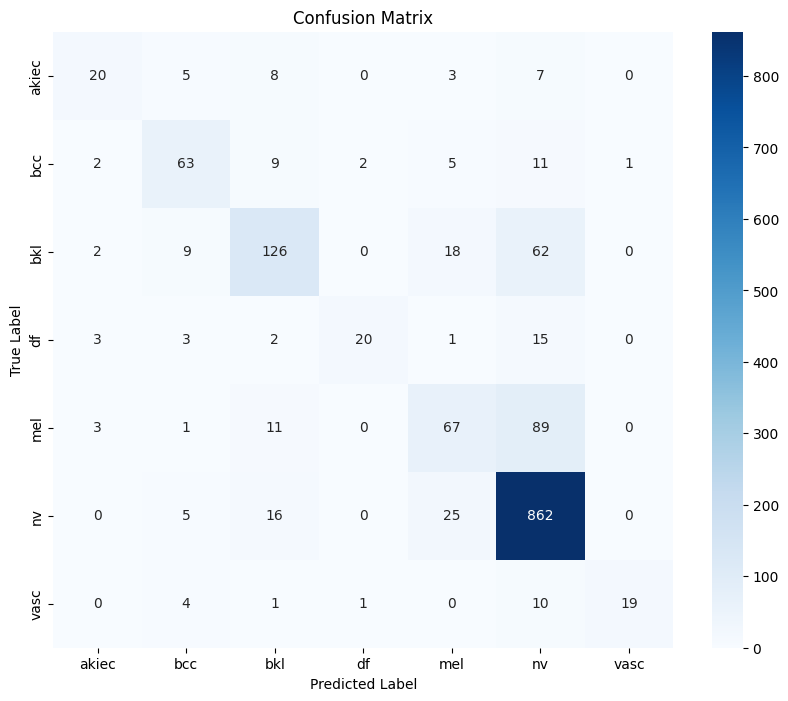

Accuracy: 77.90%
Classification Report:
               precision    recall  f1-score   support

       akiec       0.67      0.47      0.55        43
         bcc       0.70      0.68      0.69        93
         bkl       0.73      0.58      0.65       217
          df       0.87      0.45      0.60        44
         mel       0.56      0.39      0.46       171
          nv       0.82      0.95      0.88       908
        vasc       0.95      0.54      0.69        35

    accuracy                           0.78      1511
   macro avg       0.76      0.58      0.64      1511
weighted avg       0.77      0.78      0.76      1511



In [6]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SkinCancer(Dataset):
    """Skin Cancer Dataset."""

    def __init__(self, root_dir, meta, transform=None):
        """
        Args:
            root_dir (string): Path to root directory containing images
            meta_file (string): Path to csv file containing images metadata (image_id, class)
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        self.root_dir = root_dir
        self.meta = meta
        self.transform = transform

        # Load metadata from the CSV file
        self.df = pd.read_csv(self.meta)
        self.image_paths = [os.path.join(self.root_dir, f"{img_id}.jpg") for img_id in self.df['image_id']]
        self.image_ids = self.df['image_id'].to_list()
        self.classes = sorted(self.df['dx'].unique().tolist())
        self.classes_all = self.df['dx'].tolist()

        # Create class mappings
        self.class_id = {i: j for i, j in enumerate(self.classes)}
        self.class_to_id = {value: key for key, value in self.class_id.items()}
        
        self.class_count = self.df['dx'].value_counts().to_dict()
        
        # Define image transformations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 1]  # Get the image_id from the DataFrame
        img_path = os.path.join(self.root_dir, f"{img_id}.jpg") 
        label = self.df.iloc[idx, 2]
        
        # Load image
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format
        
        # Apply transformations
        if self.transform:
            image_tensor = self.transform(image)
        
        label_id = torch.tensor(self.class_to_id[str(label)])
        return image_tensor, label_id


def efficientnet():
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    old_fc = model.classifier.__getitem__(-1)
    new_fc = nn.Linear(in_features=old_fc.in_features, out_features=7, bias=True)
    model.classifier.__setitem__(-1, new_fc)
    return model

# Define the function to load the fine-tuned model weights
def load_finetuned_model(model_path):
    model = efficientnet()  # Initialize the model architecture
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load the fine-tuned weights
    return model

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# # Define paths for the test data
# test_data_folder = r"C:\Users\ramas\Downloads\dataverse_files\Aug2.0"
# csv_file_path = r"C:\Users\ramas\Downloads\Dermoscopic-image-classification-main\my-data\csv\test.csv"
test_data_folder = r"C:\Users\mohammad asfraf\Downloads\PR-Project\Datasets\ISIC2018_Task3_Test_Images\ISIC2018_Task3_Test_Images"
csv_file_path = r"C:\Users\mohammad asfraf\Downloads\PR-Project\Datasets\ISIC2018_Task3_Test_GroundTruth.csv"

# Load the dataset
test_dataset = SkinCancer(root_dir=test_data_folder, meta=csv_file_path)

# Prepare DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Adjust batch size as needed

# Load the fine-tuned model
model_path = r"C:\Users\mohammad asfraf\Downloads\PR-Project\Dermoscopic-image-classification-main\models\EfficientNet_augmented_transfer_10Epochs.pth"  # Update this with the actual path to your .pth file
model = load_finetuned_model(model_path)

# Assuming you have already defined and loaded your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Perform inference on the test dataset
all_labels = []
predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cf_matrix = confusion_matrix(all_labels, predictions)
print("Confusion Matrix:\n", cf_matrix)

# Plot the confusion matrix as a heatmap
plot_confusion_matrix(cf_matrix, test_dataset.classes)

# Compute classification metrics
accuracy = accuracy_score(all_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
class_report = classification_report(all_labels, predictions, target_names=test_dataset.classes)
print("Classification Report:\n", class_report)

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\mohammad asfraf\Downloads\PR-Project\Datasets\ISIC2018_Task3_Test_GroundTruth.csv")
df['dx']
df['dx'].value_counts()

dx
nv       908
bkl      217
mel      171
bcc       93
df        44
akiec     43
vasc      35
Name: count, dtype: int64